In [1]:
%pip install datasets transformers evaluate

from datasets import Dataset, DatasetDict
from transformers import TFRobertaForTokenClassification, RobertaTokenizerFast, DataCollatorForTokenClassification, create_optimizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

Note: you may need to restart the kernel to use updated packages.


2023-07-06 12:18:54.784933: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:18:54.822562: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 12:18:55.009614: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 12:18:55.010550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:18:55.855593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
import json

with open("annotations.json", "r") as json_file:
  data = json.load(json_file)

In [3]:
data

{'classes': ['NONE',
  'B-ORG',
  'I-ORG',
  'B-DATE',
  'I-DATE',
  'B-TIME',
  'I-TIME',
  'B-PER',
  'I-PER',
  'B-CURR',
  'I-CURR',
  'B-LOC',
  'I-LOC',
  'B-AGRE',
  'I-AGRE',
  'B-MISC',
  'I-MISC'],
 'annotations': [['EXECUTION VERSION Inveniam Private Equity Fund Demo IV. . 8500 World Trade New York, New York 10022 January 1, 2019 Maria Sharapova 31 Blandford Street London, W1U 3DN Ladies and Gentlemen: RE: Inveniam Private Equity Fund Demo IV, a Delaware limited partnership (the "Fund") This letter agreement (this "Letter Agreement") is entered into in connection with the purchase by Sharapova (the "Investor") of a limited partnership interest in the Fund. Capitalized terms used and not defined herein shall have the meanings given to them in the Fourth Amended and Restated Limited Partnership Agreement of the Fund dated as of August 27, 2021 (the "Limited Partnership Agreement"), the Subscription Agreement between the Investor and the Fund dated as of the date hereof (the "S

In [4]:
import json

In [5]:
json_object = json.dumps(data, indent = 4)

In [6]:
with open("sample.json", "w") as outfile:
    json.dump(json_object, outfile)

## Transform annotations to huggingface datadict

In [8]:
text = data["annotations"][0][0]
tags = data["annotations"][0][1]["entities"]
classes = data["classes"]

classes_dict = {}
for i in range(len(classes)):
  classes_dict[classes[i]] = i

# print(classes_dict)

tokens = []
named_tags = []

for tag in tags:
  tokens.append(text[tag[0]:tag[1]])
  named_tags.append(tag[2])


anno_dict = dict(zip(tokens, named_tags))
print(anno_dict)

all_tokens = text.split(" ")
named_labels = []
numbered_labels = []

for token in all_tokens:
  if token not in anno_dict:
    named_labels.append("NONE")
  else:
    named_labels.append(anno_dict[token])

for label in named_labels:
  numbered_labels.append(classes_dict[label])

print(all_tokens)
# print(named_labels)
print(numbered_labels)

{'Inveniam': 'B-ORG', 'Private': 'I-ORG', 'Equity': 'B-MISC', 'Fund': 'I-ORG', 'Demo': 'I-MISC', 'IV.': 'I-MISC', '8500': 'B-LOC', 'World': 'I-LOC', 'Trade': 'I-LOC', 'New': 'B-LOC', 'York': 'I-LOC', '10022': 'I-LOC', 'January': 'B-DATE', '1': 'I-DATE', '2019': 'I-DATE', 'Maria': 'B-PER', 'Sharapova': 'B-PER', '31': 'B-LOC', 'Blandford': 'I-LOC', 'Street': 'I-LOC', 'London': 'I-LOC', 'IV': 'I-MISC', 'Delaware': 'B-ORG', 'limited': 'B-MISC', 'partnership': 'I-AGRE', 'letter': 'B-AGRE', 'agreement': 'I-AGRE', '"Letter': 'B-AGRE', 'Agreement"': 'I-AGRE', '"Investor"': 'B-MISC', 'Amended': 'B-AGRE', 'Restated': 'I-AGRE', 'Limited': 'B-MISC', 'Partnership': 'I-AGRE', 'Agreement': 'I-AGRE', 'August': 'B-DATE', '27': 'I-DATE', '2021': 'I-DATE', '"Limited': 'B-AGRE', 'Subscription': 'I-AGRE', 'Investor': 'B-MISC', '"Subscription': 'B-AGRE', '$': 'B-CURR', '50,000,000': 'I-CURR', '"Capital': 'B-AGRE', 'Commitment"': 'I-AGRE', 'Capital': 'I-MISC', 'Partners': 'I-MISC', 'GP': 'I-ORG', 'L.L.C.': '

In [9]:
all_tokens_array = []
numbered_labels_array = []

temp1 = []
temp2 = []
for i in range(len(all_tokens)):
  temp1.append(all_tokens[i])
  temp2.append(numbered_labels[i])
  if i%10 == 0 and i != 0:
    all_tokens_array.append(temp1)
    numbered_labels_array.append(temp2)
    temp1 = []
    temp2 = []
all_tokens_array.append(temp1)
numbered_labels_array.append(temp2)


print(all_tokens_array)
print(numbered_labels_array)

[['EXECUTION', 'VERSION', 'Inveniam', 'Private', 'Equity', 'Fund', 'Demo', 'IV.', '.', '8500', 'World'], ['Trade', 'New', 'York,', 'New', 'York', '10022', 'January', '1,', '2019', 'Maria'], ['Sharapova', '31', 'Blandford', 'Street', 'London,', 'W1U', '3DN', 'Ladies', 'and', 'Gentlemen:'], ['RE:', 'Inveniam', 'Private', 'Equity', 'Fund', 'Demo', 'IV,', 'a', 'Delaware', 'limited'], ['partnership', '(the', '"Fund")', 'This', 'letter', 'agreement', '(this', '"Letter', 'Agreement")', 'is'], ['entered', 'into', 'in', 'connection', 'with', 'the', 'purchase', 'by', 'Sharapova', '(the'], ['"Investor")', 'of', 'a', 'limited', 'partnership', 'interest', 'in', 'the', 'Fund.', 'Capitalized'], ['terms', 'used', 'and', 'not', 'defined', 'herein', 'shall', 'have', 'the', 'meanings'], ['given', 'to', 'them', 'in', 'the', 'Fourth', 'Amended', 'and', 'Restated', 'Limited'], ['Partnership', 'Agreement', 'of', 'the', 'Fund', 'dated', 'as', 'of', 'August', '27,'], ['2021', '(the', '"Limited', 'Partnership',

In [10]:
print(classes_dict)

{'NONE': 0, 'B-ORG': 1, 'I-ORG': 2, 'B-DATE': 3, 'I-DATE': 4, 'B-TIME': 5, 'I-TIME': 6, 'B-PER': 7, 'I-PER': 8, 'B-CURR': 9, 'I-CURR': 10, 'B-LOC': 11, 'I-LOC': 12, 'B-AGRE': 13, 'I-AGRE': 14, 'B-MISC': 15, 'I-MISC': 16}


In [11]:
data_dict = {
    "tokens" : all_tokens_array,
    "labels" : numbered_labels_array
}

dataset = Dataset.from_dict(data_dict)

dataset_dict = DatasetDict({"train": dataset})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels'],
        num_rows: 250
    })
})


In [12]:
dataset_dict['train'][15]

{'tokens': ['$50,000,000',
  'as',
  'of',
  'the',
  'date',
  'hereof',
  '(the',
  '"Capital',
  'Commitment"),',
  'Inveniam'],
 'labels': [0, 0, 0, 0, 0, 0, 0, 13, 0, 1]}

### Modeling

In [13]:
model_id = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_id, add_prefix_space=True)

In [14]:
inputs = tokenizer(dataset_dict["train"][15]["tokens"], is_split_into_words=True,)
inputs.tokens()

['<s>',
 'Ġ$',
 '50',
 ',',
 '000',
 ',',
 '000',
 'Ġas',
 'Ġof',
 'Ġthe',
 'Ġdate',
 'Ġhere',
 'of',
 'Ġ(',
 'the',
 'Ġ"',
 'Capital',
 'ĠCommit',
 'ment',
 '"),',
 'ĠIn',
 'ven',
 'iam',
 '</s>']

In [15]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [16]:
inputs = tokenizer(dataset_dict["train"][1]["tokens"], is_split_into_words=True,)
print(inputs.tokens())
print(dataset_dict["train"][1]["tokens"])
print(dataset_dict['train'][1]['labels'])
print(inputs.word_ids())
print(align_labels_with_tokens(dataset_dict['train'][1]['labels'], inputs.word_ids()))

['<s>', 'ĠTrade', 'ĠNew', 'ĠYork', ',', 'ĠNew', 'ĠYork', 'Ġ100', '22', 'ĠJanuary', 'Ġ1', ',', 'Ġ2019', 'ĠMaria', '</s>']
['Trade', 'New', 'York,', 'New', 'York', '10022', 'January', '1,', '2019', 'Maria']
[12, 11, 0, 11, 12, 12, 3, 0, 4, 7]
[None, 0, 1, 2, 2, 3, 4, 5, 5, 6, 7, 7, 8, 9, None]
[-100, 12, 11, 0, 0, 11, 12, 12, 12, 3, 0, 0, 4, 7, -100]


In [17]:
labels = dataset_dict["train"][23]["labels"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[0, 0, 15, 0, 0, 0, 0, 0, 0, 0]
[-100, 0, 0, 15, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


In [18]:
# print(dataset_dict['train']['labels'])

In [19]:
def tokenizer_function(dataset):
  out = tokenizer(dataset['tokens'],truncation=True,is_split_into_words=True,)
#   print("out ----> ", out)
  out['labels'] = align_labels_with_tokens(dataset['labels'],out.word_ids())
  return out

In [20]:
dataset_dict['train'][15]

{'tokens': ['$50,000,000',
  'as',
  'of',
  'the',
  'date',
  'hereof',
  '(the',
  '"Capital',
  'Commitment"),',
  'Inveniam'],
 'labels': [0, 0, 0, 0, 0, 0, 0, 13, 0, 1]}

In [21]:
# print(dataset_dict)
tokenized_dataset = dataset_dict.map(tokenizer_function, remove_columns=['tokens'])

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [22]:
# tokenized_dataset['train'][15]

In [23]:
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, return_tensors="tf"
)

In [24]:
BATCH_SIZE = 10
NUM_EPOCHS = 5

In [25]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=True,
    batch_size=BATCH_SIZE
)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [26]:
# taking the train data as validation data also
tf_val_dataset = tokenized_dataset["train"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

In [27]:
model = TFRobertaForTokenClassification.from_pretrained(
    model_id,
    num_labels=17
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForTokenClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model.summary()

Model: "tf_roberta_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  13073     
                                                                 
Total params: 124,068,113
Trainable params: 124,068,113
Non-trainable params: 0
_________________________________________________________________


In [32]:
# batch size
batches_per_epoch = len(tokenized_dataset["train"])

total_train_steps = int(batches_per_epoch*NUM_EPOCHS)

In [33]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps,)

In [34]:
model.compile(optimizer=optimizer)

In [35]:
history=model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=NUM_EPOCHS,)

Epoch 1/5
25/25 [==============================] - 64s 2s/step - loss: 1.4395 - val_loss: 0.8783
Epoch 2/5
25/25 [==============================] - 50s 2s/step - loss: 0.8048 - val_loss: 0.6489
Epoch 3/5
25/25 [==============================] - 45s 2s/step - loss: 0.6331 - val_loss: 0.5210
Epoch 4/5
25/25 [==============================] - 43s 2s/step - loss: 0.5262 - val_loss: 0.3986
Epoch 5/5
25/25 [==============================] - 45s 2s/step - loss: 0.4125 - val_loss: 0.2801


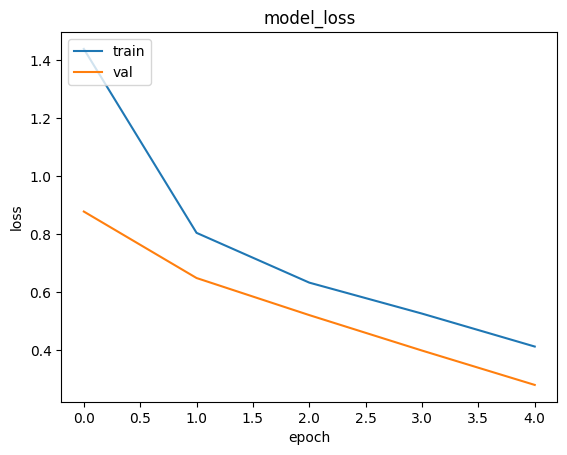

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Testing

In [37]:
model_inputs = tokenizer(['''Third Party Investor is a Comparable Investor, the investment of such Third Party Investor in the Fund, the Sister Fund or the SFRO Feeder may'''], padding=True, return_tensors='tf')

In [38]:
tokenized_tokens = model_inputs.tokens()
print(tokenized_tokens)

['<s>', 'ĠThird', 'ĠParty', 'ĠInvestor', 'Ġis', 'Ġa', 'ĠCompar', 'able', 'ĠInvestor', ',', 'Ġthe', 'Ġinvestment', 'Ġof', 'Ġsuch', 'ĠThird', 'ĠParty', 'ĠInvestor', 'Ġin', 'Ġthe', 'ĠFund', ',', 'Ġthe', 'ĠSister', 'ĠFund', 'Ġor', 'Ġthe', 'ĠS', 'FR', 'O', 'ĠFeed', 'er', 'Ġmay', '</s>']


In [39]:
print(model_inputs['input_ids'])

tf.Tensor(
[[    0  7470  1643 11506    16    10 20492   868 11506     6     5   915
      9   215  7470  1643 11506    11     5  2896     6     5 18319  2896
     50     5   208  5499   673 17703   254   189     2]], shape=(1, 33), dtype=int32)


In [40]:
logits = model(**model_inputs).logits
print(logits.shape)
output_array = tf.argmax(logits,axis=-1)
print(output_array)

(1, 33, 17)
tf.Tensor(
[[ 0 15 16 15  0  0 15 16 15  0  0  0  0  0 15 16 15  0  0  0  0  0  2  2
   0  0  2  2  2  2  2  0  0]], shape=(1, 33), dtype=int64)


In [41]:
named_labels = []
values = list(classes_dict.values())
keys = list(classes_dict.keys())

for output in output_array[0]:
    # print(output)
    pos = values.index(output)
    named_labels.append(keys[pos])

In [42]:
# test outputs
size = len(named_labels)

for i in range(size):
    if(named_labels[i]== 'I-ORG'):
        print(tokenized_tokens[i], ' --> ', named_labels[i])


ĠSister  -->  I-ORG
ĠFund  -->  I-ORG
ĠS  -->  I-ORG
FR  -->  I-ORG
O  -->  I-ORG
ĠFeed  -->  I-ORG
er  -->  I-ORG
